In [ ]:
#@title Install dependencies { display-mode: "form" }
!pip install biopython
!pip install pyperclip
!pip install umap-learn[plot]
!pip install holoviews

# sys.path.append('/usr/local/lib/python3.9/site-packages/') #append site-packages to path to run conda/mmseqs2/cd-hit

!wget https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!bash ./Miniconda3-py39_23.3.1-0-Linux-x86_64.sh -b -f -p /usr/local
# install via conda
!conda install -c conda-forge -c bioconda mmseqs2


In [7]:
#@title Mount drive and load libraries { display-mode: "form" }
import os
from google.colab import drive

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc_project'
os.chdir(path)

import pandas as pd
import sys, numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting functionality
from useful_functions import fasta_to_df, df_to_fasta, add_counts

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
#@title Generate fasta file for clustering
df = pd.read_csv('all_paired/230716_human_paired_seqs.csv', low_memory=False)
df = df.iloc[:, 2:]
df.head()
tensors = pd.read_csv('all_paired/230716_scfv_10000.csv')
names = tensors['seq'].to_list()

df = df[df['seq_id'].isin(names)]

def df_to_fasta(df: pd, cols: list, f: str):
    x = cols[0]
    y = cols[1]
    with open(f, 'w') as out:
        for i in range(df.shape[0]):
            out.write('>' + df[x].iloc[i] + '\n' + df[y].iloc[i] + '\n')

df_to_fasta(df=df, cols=['seq_id', 'scfv'], f='230716_scfv_10000.fasta')

In [13]:
#@title Cluster sequences
os.chdir('/tmp')
!mkdir /tmp/new_tmp
!cp /content/drive/MyDrive/msc_project/all_paired/230716_scfv_10000.fasta /tmp

!sudo mmseqs easy-cluster 230716_scfv_10000.fasta clusterRes new_tmp --min-seq-id 0.8 -c 0.8 --cov-mode 1

!mv /tmp/clusterRes_all_seqs.fasta /content/drive/MyDrive/msc_project/all_paired
!mv /tmp/clusterRes_cluster.tsv /content/drive/MyDrive/msc_project/all_paired
!mv /tmp/clusterRes_rep_seq.fasta /content/drive/MyDrive/msc_project/all_paired

os.chdir('/content/drive/MyDrive/msc_project/all_paired')

mkdir: cannot create directory ‘/tmp/new_tmp’: File exists
easy-cluster 230716_scfv_10000.fasta clusterRes new_tmp --min-seq-id 0.8 -c 0.8 --cov-mode 1 

MMseqs Version:                     	13.45111
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	4
k-mer length                        	0
k-score                             	2147483647
Alphabet size                       	nucl:5,aa:21
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask lower case residues            	0
Mi

In [16]:
#@title Generate clusters from ID pairings
clus = pd.read_csv('clusterRes_cluster.tsv', sep='\t', header=None)

# Create a dictionary to store the cluster numbers
cluster_dict = {}

# Iterate over the rows of the dataframe
for idx, row in clus.iterrows():
    id1 = row[0]
    id2 = row[1]

    # Check if id1 or id2 already have a cluster assigned
    if id1 in cluster_dict and id2 not in cluster_dict:
        cluster_dict[id2] = cluster_dict[id1]
    elif id1 not in cluster_dict and id2 in cluster_dict:
        cluster_dict[id1] = cluster_dict[id2]
    elif id1 not in cluster_dict and id2 not in cluster_dict:
        # Assign a new cluster number
        new_cluster = len(cluster_dict)
        cluster_dict[id1] = new_cluster
        cluster_dict[id2] = new_cluster

# Assign cluster numbers to the original dataframe
clus['cluster'] = clus[0].map(cluster_dict)

# Create a single column of unique IDs with respective cluster numbers
l = clus['cluster'].to_list() + clus['cluster'].to_list()
new = pd.concat([clus[0], clus[1]])
new = pd.DataFrame(new)
new['cluster'] = l

new.drop_duplicates(subset=0, inplace=True)
new.rename(columns={0:'seq'}, inplace=True)

test = new.merge(right=tensors, how='left', on='seq')
test.drop(columns=['Unnamed: 0'], inplace=True)

num_clus = len(set(test['cluster']))

print(f'{num_clus} clusters in this set')
test.head()

1820 clusters in this set


,seq,cluster,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,GTCAAGTCACTGTCGG-1_contig_1_GTCAAGTCACTGTCGG-1...,0,0.018020,0.08887,0.01721,0.004787,-0.02261,0.03925,-0.029250,-0.08070,...,-0.07690,0.03980,-0.06630,-0.08170,-0.011060,-0.001887,0.04450,0.04416,0.016660,-0.007225
1,GTGCGGTCAAAGTGCG-1_contig_2_GTGCGGTCAAAGTGCG-1...,1,0.015495,0.09740,0.02005,-0.008680,-0.03345,0.02898,-0.007168,-0.07880,...,-0.08356,0.00972,-0.06775,-0.07196,-0.042000,-0.013530,0.03550,0.05917,0.013040,0.005714
2,TACACGATCTTCAACT-1_contig_2_TACACGATCTTCAACT-1...,17,0.005905,0.09920,0.01680,-0.003012,-0.01474,0.02577,-0.013560,-0.09860,...,-0.08840,0.01445,-0.06177,-0.07850,-0.015144,-0.015870,0.01157,0.05975,0.002142,-0.010560
3,TACTTACCATCACAAC-1_contig_2_TACTTACCATCACAAC-1...,19,-0.003359,0.10920,0.02408,0.000740,-0.01773,0.03726,-0.020980,-0.08840,...,-0.09820,0.02623,-0.05954,-0.07200,-0.012650,-0.001715,0.00554,0.04020,0.003582,-0.017960
4,TAGGCATCAGTCCTTC-1_contig_2_TAGGCATCAGTCCTTC-1...,20,0.010260,0.10266,0.02391,0.002360,-0.01804,0.04443,-0.020360,-0.08704,...,-0.09094,0.02162,-0.06520,-0.07110,-0.009450,-0.007336,0.02809,0.04114,-0.002392,-0.009550


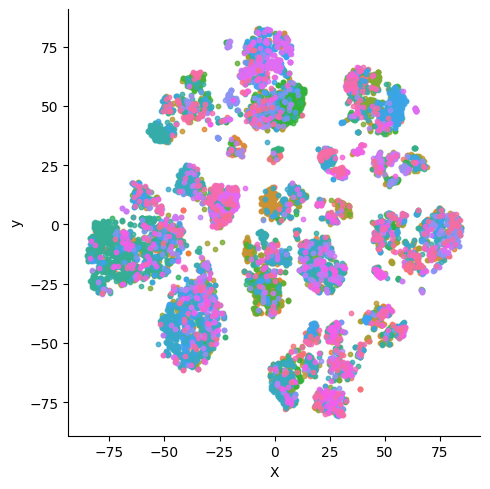

In [18]:
tsne = TSNE(n_components=2, random_state=42)

test = test.dropna()
protein_tsne = tsne.fit_transform(test.iloc[:,2:])

X=protein_tsne[:, 0]
y=protein_tsne[:, 1]
metadata = test['cluster']  # Convert to string type

new_df = pd.DataFrame({'X': X, 'y': y, 'metadata': metadata})

# Set scatter plot parameters for smaller points
scatter_kws = {'s': 10}  # Adjust the 's' value to control point size

if num_clus < 20:
  boolie = True
else:
  boolie = False

# Use the 'hue' argument to provide a factor variable
sns.lmplot(x='X', y='y', data=new_df, hue='metadata', fit_reg=False, legend=boolie, scatter_kws=scatter_kws)

plt.show()

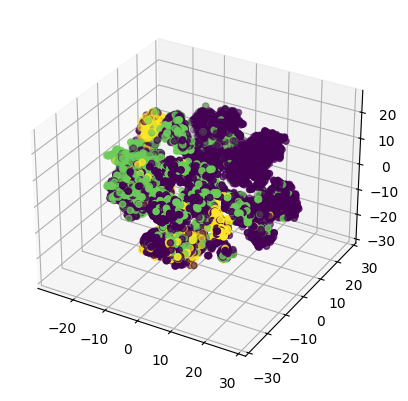

In [ ]:
tsne = TSNE(n_components=3, random_state=42)  # Set n_components to 3

protein_tsne = tsne.fit_transform(test.iloc[:, 2:])

X = protein_tsne[:, 0]
y = protein_tsne[:, 1]
z = protein_tsne[:, 2]  # New component 'z'
metadata = test['cluster']

new_df = pd.DataFrame({'X': X, 'y': y, 'z': z, 'metadata': metadata})

# # Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Use the 'hue' argument to provide a factor variable
ax.scatter(new_df['X'], new_df['y'], new_df['z'], c=new_df['metadata'])

plt.show()


Running into issues with UMAP. For some reason the conda forge and pip don't result in a functioning import.

Fix next time and also implement kmeans and see whether it does anything useful. Use metrics such as cluster purity to see whether kmeans can pick clusters that overlap with mmseqs2. Are there any other ways you can generate 'labels' for how similar antibodies are? Maybe concatenating the light and heavy chain V segments?


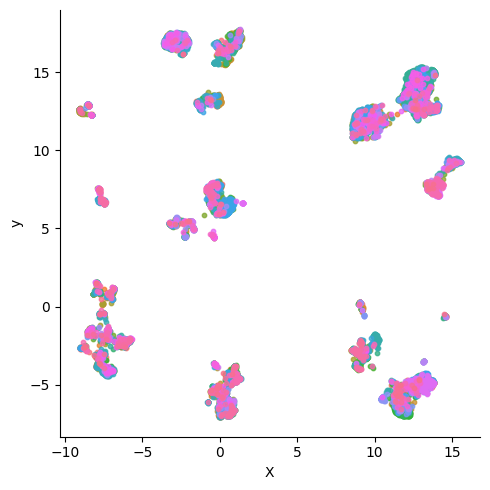

In [19]:
umap_embedding = umap.UMAP(n_components=2, random_state=42)
protein_umap = umap_embedding.fit_transform(test.iloc[:, 2:])
X = protein_umap[:, 0]
y = protein_umap[:, 1]
metadata = test['cluster']

new_df = pd.DataFrame({'X': X, 'y': y, 'metadata':metadata})

# Set scatter plot parameters for smaller points
scatter_kws = {'s': 10}  # Adjust the 's' value to control point size

if num_clus < 20:
  boolie = True
else:
  boolie = False

# Use the 'hue' argument to provide a factor variable
sns.lmplot(x='X', y='y', data=new_df, hue='metadata', fit_reg=False, legend=boolie, scatter_kws=scatter_kws)

#plt.scatter(new_df['X'], new_df['y'])

plt.show()

In [9]:
# import numpy as np
# import umap
# import holoviews as hv

# # Generate a random dataset
# data = np.random.rand(100, 3)

# # Create a UMAP object
# reducer = umap.UMAP(n_neighbors=10, min_dist=0.1)

# # Fit and transform the data
# embedding = reducer.fit_transform(data)
hv.extension('matplotlib')
# Visualize the embedding
hv.Points(embedding).opts(color='k', marker='+', s=50)

Output hidden; open in https://colab.research.google.com to view.